In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import glob
# import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
# import tensorflow as tf
import sys
sys.path.insert(0, '../.')
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
# from Trainer import *
from evaluation.evaluate import *
from data.postprocessing.nms import *
from scipy.spatial.transform import Rotation as R

/Users/apple/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/apple/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
training=True
base_path = '/Users/apple/Desktop/Master/Data/'
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)

camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
ln = int(len(list_files) * 0.5)
final_sample = len(list_files)

# ln = int(10 * 0.5)
# final_sample = 10
        
if training:
            list_files = list_files[:ln]
            list_camera_paths = camera_paths[:ln]
            list_lidar_paths = lidar_paths[:ln]
            list_label_paths = label_paths[:ln]
            list_calib_paths = calib_paths[:ln]
else:
            list_camera_paths = camera_paths[ln:final_sample]
            list_lidar_paths = lidar_paths[ln:final_sample]
            list_label_paths = label_paths[ln:final_sample]
            list_calib_paths = calib_paths[ln:final_sample]
            list_files = list_files[ln:final_sample]


In [4]:
i_c = 3
current_file = list_files[i_c]
current_file

'000007'

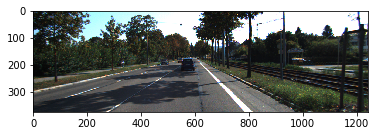

In [5]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [22]:
r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
rot = r.as_dcm()
rot = np.append(rot, np.array([[0,0,0]]), axis=0)
rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

tr_x = 0
tr_y = 0
tr_z = -1
tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

sc_x = 1
sc_y = 1
sc_z = 1
sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

In [23]:

# current_file = list_files2[3]
    
translate_x = 0
translate_y = 0
translate_z = 0
ang = 0
fliplr = False

# i_c = 25
# current_file = list_files2[i_c]
# current_file

h, w, _ = cv2.imread(base_path + '/data_object_image_3/training/image_3/'+ current_file + '.png').shape
all_data, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(rot, tr, sc, base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True,
                                                         ang=ang, translate_x=translate_x,
                                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

tr_x = 0
tr_y = 0
tr_z *=-1
tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
lidar_image = velo_points_bev(rot, tr, sc, base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin',
                              base_path + '/data_object_calib/training/calib/'+ current_file + '.txt',
                           size=(512, 448, 40), img_height=375, img_width=1242, ang=ang, translate_x=translate_x,
                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

# label = get_target(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))

(512, 448)
329.91820033083116 220.53869700630193 23.027972156620923 9.27590659683491 -88.80849
167.69964152453446 182.85417136928538 26.625749119085842 8.437902895147813 -88.80849
74.36545760985553 198.05234536958528 29.146276577268303 9.27511512851497 -89.381448



<Figure size 432x288 with 0 Axes>

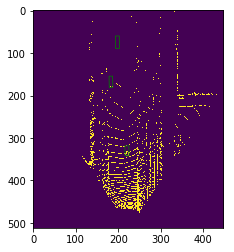

In [24]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 20:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]

    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


<Figure size 432x288 with 0 Axes>

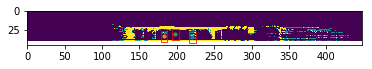

In [25]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    


plt.show()


In [21]:
((random.random() * 2) - 1.) / 10.

0.01667640789100624

In [22]:
image_size = (370, 1224)
camera_path = base_path + '/data_object_image_3/training/image_3/'+ current_file + '.png'
lidar_path = base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin'
calib_path = base_path + '/data_object_calib/training/calib/'+ current_file + '.txt'
lidar_size = (512, 448, 40)
label_path = base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt'

In [23]:
if True:

                    if np.random.random_sample() >= 0.5:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.5:
                        translate_x = random.randint(-5, 5)
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        translate_y = random.randint(-5, 5)
                    else:
                        translate_y = 0
                    # translate_z = random.random() - 0.5
                    if np.random.random_sample() >= 0.8:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.3:
                        ang = random.randint(-5, 5)
                    else:
                        ang = 0
                    fliplr = False

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1

                    if np.random.random_sample() >= 0.5:
                       sc_x += ((random.random() * 2) - 1.) / 10.

                    if np.random.random_sample() >= 0.5:
                       sc_y += ((random.random() * 2) - 1.) / 10.


                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    

else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0
                    fliplr = False

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])


camera_image, shift_h, shift_w = read_camera(camera_path, image_size, image_translate_x, image_translate_y, fliplr=fliplr)
h, w, _ = cv2.imread(camera_path).shape
lidar_image = read_lidar(rot, tr, sc, lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y, fliplr=fliplr)

                # if training:
                #     if np.random.random_sample() >= 0.8:
                #         noise = np.random.rand(512, 448, 40)
                #         noise2 = np.random.rand(512, 448, 40)

                #         noise = np.array(noise>=0.99, dtype=np.int)
                #         noise2 = np.array(noise2>=0.99, dtype=np.int)

                #         lidar_image = np.array(np.clip(lidar_image + noise*noise2*255, 0, 255), dtype=np.int)

                #     if np.random.random_sample() >= 0.8:
                #         noise = np.random.rand(512, 448, 40)
                #         noise2 = np.random.rand(512, 448, 40)

                #         noise = np.array(noise>=0.1, dtype=np.int)
                #         noise2 = np.array(noise2>=0.1, dtype=np.int)

                #         lidar_image = np.array(np.clip(lidar_image * noise*noise2, 0, 255), dtype=np.int)

_, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(rot, tr, sc, label_path, calib_path, shift_h, shift_w, translate_x=translate_x,\
                                                               translate_y=translate_y, ang=ang, fliplr=fliplr, get_actual_dims=True)
# label = get_target(label, directions,  anchors=anchors)
camera_image = camera_image / 255.
# lidar_image = (lidar_image - 127.) / 127.
#                 yield(camera_image, lidar_image, label,
#                                     np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
#                                     np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
#                                     np.array(P3).reshape((3, 4)), 
#                                     np.array([shift_h]), 
#                                     np.array([shift_w])
#                                     )


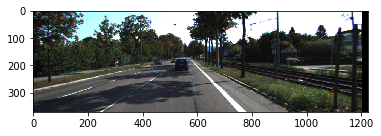

In [24]:
plt.imshow(camera_image)

In [25]:
image_translate_x, image_translate_x, tr_x , tr_y, tr_z

(-23, -23, 0, 3, -0.36072629480184737)

(512, 448)
319.3965123195744 210.88792655742034 24.202242563432463 9.498174278659583 -91.80849
146.4419976820759 179.11123498347655 27.98445337352662 8.63957622504876 -91.80849
49.5441890968998 198.5299031822308 30.626885386447338 9.500383195319005 -92.38144799999999



<Figure size 432x288 with 0 Axes>

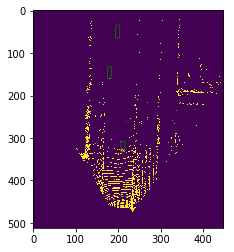

In [26]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 15:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
#     plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


In [27]:
sc_x

1.0511608408314448